## Dependencias

In [1]:
import numpy as np
import pandas as pd
import os
import json
from sqlalchemy.engine import create_engine

import matplotlib.pyplot as plt
import seaborn as sns
import cufflinks as cf
from scikitplot.metrics import plot_roc

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score


from scipy import stats
from varclushi import VarClusHi

from functools import reduce

import pickle
import asyncio
import warnings

warnings.filterwarnings('ignore')
pd.set_option('display.max_columns',None)
cf.go_offline()

In [2]:
def freq(df,var):
    if type(var)!=list:
        var = [var]
    for v in var:
        aux = df[v].value_counts().sort_index().to_frame().rename(columns={v:'FA'})
        aux['FR'] = aux['FA']/aux['FA'].sum()
        aux[['FAA','FRA']] = aux.apply(np.cumsum)
        print("Tabla de frecuencias para la variable **",v,"**","\n"*2)
        print(aux,"\n"*2)

In [3]:
dic=pd.read_excel('SIMAEC_NPS_Dic.xlsx')
nov=pd.read_excel('SIMAEC_NPS_Nov.xlsx')
oc= pd.read_excel('SIMAEC_NPS_Oct.xlsx')
sep=pd.read_excel('SIMAEC_NPS_Sep.xlsx')
ago=pd.read_excel('SIMAEC_NPS_Ago.xlsx')
jul=pd.read_excel('SIMAEC_NPS_Jul.xlsx')
jun=pd.read_excel('SIMAEC_NPS_Jun.xlsx')
may=pd.read_excel('SIMAEC_NPS_May.xlsx')
abr=pd.read_excel('SIMAEC_NPS_Abr.xlsx')
mar=pd.read_excel('SIMAEC_NPS_Mar.xlsx')
feb=pd.read_excel('SIMAEC_NPS_Feb.xlsx')
ene=pd.read_excel('SIMAEC_NPS_Ene.xlsx')

In [92]:
df=pd.concat([ene,feb,mar,abr,may,jun,jul,ago,sep,oc,nov,dic])

In [93]:
df.shape

(426630, 11)

In [6]:
a=[]
for file in os.listdir(r'C:\Users\VDMG015\Documents\Esteban\Tramites\Datos'):
        cdmx = pd.read_csv('Datos/'+file, dtype='str', usecols=['StartDate','telefonoUsuario','Q6'])
        cdmx = cdmx.iloc[2:].reset_index(drop=True)
        cdmx['StartDate']=pd.to_datetime(cdmx['StartDate'], format='%Y-%m-%d')
        cdmx['StartDate']=cdmx['StartDate'].dt.date
        cdmx = cdmx.rename(columns={'telefonoUsuario':'linea','StartDate':'fecha','Q6':'Solucion'})
        cdmx['fecha'] = cdmx['fecha'].astype(str)
        cdmx['Solucion'] = cdmx['Solucion'].replace({'Sí, y estoy satisfecho con el resultado.':'Sí', 'Sí, pero no estoy satisfecho con el resultado.':'Sí','No, mi requerimiento/trámite no se resolvió.':'No' })
        print(file)
        a.append(cdmx)
qx=pd.concat(a)

Encuesta CAC F_22 diciembre 2021_12.49.csv
Encuesta CAC F_23 diciembre 2021_17.34.csv
Encuesta CAC F_24 diciembre 2021_12.52.csv
Encuesta CAC F_24 diciembre 2021_13.00.csv


In [7]:
qx.drop_duplicates().shape, qx.shape

((875429, 3), (879918, 3))

In [94]:
qx=qx.drop_duplicates().reset_index(drop=True)

In [95]:
df['region']=df['region'].astype(str)

In [96]:
df['tramites']=df['tramites'].astype(str)

In [97]:
df['linea'] = df['linea'].astype(str)

In [98]:
df=df.merge(qx)

In [99]:
df=df[df['NPS_Asesor'].isin(['Detractor','Promotor'])].reset_index(drop=True)
df=df.dropna().reset_index(drop=True)

In [100]:
df=df.rename(columns={'tiempo_espera':'c_tiempo_espera','tiempo_tramite':'c_tiempo_tramite','motivo':'d_motivo'})

In [101]:
df['target']=(df['NPS_Asesor']=='Promotor').astype(int)

In [102]:
df=df[df['Solucion']=='No'].reset_index(drop=True)

## Variables

In [103]:
um = ['linea','fecha']
varc = [v for v in df.columns if v[:2]=='c_']
vard = [v for v in df.columns if v[:2]=='d_']
vart =['target']
len(varc),len(vard)

(2, 1)

In [104]:
df=df.drop_duplicates(um).reset_index(drop=True)

## Análisis Exploratorio

#### Varianza Nula

In [105]:
vt = VarianceThreshold()
vt.fit(df[varc])

VarianceThreshold()

In [106]:
df[varc]

,c_tiempo_espera,c_tiempo_tramite
0,57,557
1,462,1998
2,65,80
3,276,1735
4,3483,1275
...,...,...
66767,36,1238
66768,31,4675
66769,30,1037
66770,572,394


In [107]:
vt.transform(df[varc])

array([[  57,  557],
       [ 462, 1998],
       [  65,   80],
       ...,
       [  30, 1037],
       [ 572,  394],
       [ 754,  744]], dtype=int64)

In [108]:
varc = [v for v,f in zip(varc,vt.get_support()) if f]
len(varc)

2

In [109]:
varc

['c_tiempo_espera', 'c_tiempo_tramite']

#### Discretización

In [110]:
df['d_c_tiempo_espera']=pd.cut(df['c_tiempo_espera'],bins=[0]+[(30*2**x) for x in range(5)]+[900, np.inf],right=True, labels=['(0 - 30seg]', '(30seg - 1min]', '(1min - 2min]', '(2min - 4min]', '(4min - 8min]', '(8min - 15min]', '+15']).astype(str)
df['d_c_tiempo_tramite']=pd.cut(df['c_tiempo_tramite'],bins=[x*60 for x in range(0,70,10)] + [np.inf],right=True, labels=['(0 - 10min]', '(10min - 20min]', '(20min - 30min]', '(30min - 40min]', '(40min - 50min]', '(50min - 60min]', '+1hr']).astype(str)

In [125]:
def discretizar(k,metodo,variable):
    nm = df[um+[variable]].copy()

    kb = KBinsDiscretizer(n_bins=k,encode='ordinal',strategy=metodo)
    kb.fit(nm[[variable]])

    nm['d'] = kb.transform(nm[[variable]])
    mapa = dict(zip(range(k),['%02d. |%.1f---%.1f|'%(i+1,*s) for i,s in enumerate(list(zip(kb.bin_edges_[0],kb.bin_edges_[0][1:])))]))
    nm['d'].replace(mapa,inplace=True)
    nombre = f'd_{metodo[0]}_{k}_{variable}'
    nm = nm[um+['d']].rename(columns={'d':nombre})
    
    return nm

In [126]:
l=[]
for i in [(k,m,v) for k in range(2,6) for m in ['quantile','uniform'] for v in varc]:
    a,b,c=i
    l.append(discretizar(a,b,c).iloc[:,2])

In [127]:
dfd=pd.concat(l,axis=1)

In [128]:
dfd[um]=df[um]

In [111]:
varcd = ['d_c_tiempo_tramite','d_c_tiempo_espera']

In [112]:
df

,linea,fecha,c_tiempo_espera,c_tiempo_tramite,tramites,d_motivo,cac,region,Asesor,NPS_Asesor,NPS_CAC,Solucion,target,d_c_tiempo_espera,d_c_tiempo_tramite
0,2211088321,2021-01-25,57,557,1,T INFORMES DE CONTRATACION Y PRECIOS DE EQUIPOS,SAN PEDRO,7,PAC29AA,Detractor,Detractor,No,0,(30seg - 1min],(0 - 10min]
1,2211757242,2021-01-14,462,1998,2,A INFORME DE TARIFAS DE VOZ Y DATOS,PUEBLA V,7,PACCA54,Detractor,Detractor,No,0,(4min - 8min],(30min - 40min]
2,2211963790,2021-01-28,65,80,1,T MIGRACION A PREPAGO,CAC AMALUCAN,7,PAC7BA5,Detractor,Detractor,No,0,(1min - 2min],(0 - 10min]
3,2212022505,2021-01-05,276,1735,1,T POR CIRCULO AZUL,PUE II SAN ANGEL,7,PACB267,Detractor,Detractor,No,0,(4min - 8min],(20min - 30min]
4,2212035422,2021-01-17,3483,1275,1,T COTIZACION DE PUNTOS DE CIRCULO AZUL,HUEXOTITLA,7,PAC10592,Detractor,Detractor,No,0,+15,(20min - 30min]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66767,9999693514,2021-12-10,36,1238,1,COTIZACION PARA RENOVACION.,GRAN PLAZA,8,RAC3574,Detractor,Detractor,No,0,(30seg - 1min],(20min - 30min]
66768,9999931364,2021-12-03,31,4675,2,A VENTA DE AMIGO KIT,MERIDA IV,8,RAC9AF3,Promotor,Promotor,No,1,(30seg - 1min],+1hr
66769,9999974393,2021-12-11,30,1037,1,T PROPIO (SWITCHEO),CAC MERIDA V ALTABRISA,8,RACED45,Detractor,Detractor,No,0,(0 - 30seg],(10min - 20min]
66770,9999975058,2021-12-08,572,394,1,T SERVICIOS CON TERCEROS AGREGADORES,ITZAES,8,RAC33B7,Detractor,Detractor,No,0,(8min - 15min],(0 - 10min]


### Discreto

#### Normalización

In [113]:
def normalizar(df,v,umbral=10):
    aux = df[v].value_counts(True).to_frame()
    aux[f'norm_{v}'] = np.where(aux[v]<umbral,'PEQUEÑAS CATEGORÍAS',aux.index)
    moda = aux.head(1)[f'norm_{v}'].values[0]
    if aux.loc[aux[f'norm_{v}']=='PEQUEÑAS CATEGORÍAS'][v].sum()<umbral:
        aux[f'norm_{v}'].replace({'PEQUEÑAS CATEGORÍAS':moda},inplace=True)
    aux.drop(v,axis=1,inplace=True)
    aux.reset_index(inplace=True)
    return v,aux[aux['index']!=aux[f'norm_{v}']].set_index('index').to_dict()[f'norm_{v}']

In [114]:
df['n_d_motivo']=df['d_motivo'].replace(normalizar(df,'d_motivo',0.005)[1])

In [115]:
varn = [v for v in df.columns if v[:2]=='n_']

In [116]:
freq(df,varn)

Tabla de frecuencias para la variable ** n_d_motivo ** 


                                                       FA        FR    FAA  \
A CONFIGURACION / FUNCIONES DEL EQUIPO                525  0.007863    525   
A FICHA / RECARGA ELECTRONICA                         559  0.008372   1084   
A INFORMES DE PORTABILIDAD                            496  0.007428   1580   
A INFORMES DE PRECIOS DE EQUIPOS                      798  0.011951   2378   
A INFORMES MIGRACION PREPAGO A POSTPAGO               428  0.006410   2806   
A INGRESO Y ENTREGA DE EQUIPO (REVISION / REPAR...   1950  0.029204   4756   
A POR ACTUALIZACION VERSION                           466  0.006979   5222   
A POR ROBO Y/O EXTRAVIO                               451  0.006754   5673   
A POR SALDO DE VOZ                                    981  0.014692   6654   
A VENTA DE AMIGO KIT                                 1146  0.017163   7800   
ACLARACION DE SALDO                                   615  0.009210   8415   
C ACLA

### Unarias

In [117]:
unarias = [v for v,n in map(lambda v:(v,df[v].nunique()),varn+varcd) if n ==1]
df.drop(unarias,axis=1,inplace=True)
varn = [v for v in varn if v not in unarias]
varcd = [v for v in varcd if v not in unarias]

In [118]:
varcd

['d_c_tiempo_tramite', 'd_c_tiempo_espera']

## Análisis bi-variado

In [119]:
def calcularIV(df,v,tgt):
    aux = df[[v]+tgt].copy().assign(n=1)
    aux = aux.pivot_table(index=v,columns=tgt,values='n',aggfunc='sum',fill_value=0)
    aux/=aux.sum()
    aux['w'] = np.log(aux[0]/aux[1])
    aux['iv'] = (aux[0]-aux[1])*aux['w']
    return v,aux['iv'].sum()

In [120]:
ivreport = pd.DataFrame(map(lambda v:calcularIV(df,v,vart),varn+varcd),columns=['var','iv'])

In [121]:
ivreport = ivreport.loc[(ivreport['iv']>=0.01)&(~np.isinf(ivreport['iv']))].reset_index(drop=True)

In [122]:
ivreport['raíz'] = ivreport['var'].map(lambda x:x if x[:2]=='n_' else "_".join(x.split('_')[3:]))

In [123]:
ivreport

,var,iv,raíz
0,n_d_motivo,0.037100,n_d_motivo
1,d_c_tiempo_tramite,0.032952,tramite


In [124]:
best = list(ivreport.sort_values(by=['raíz','iv'],ascending=[1,0]).groupby('raíz').first()['var'])

In [125]:
best=varcd+varn

In [126]:
df=df.dropna().reset_index(drop=True)

In [127]:
best

['d_c_tiempo_tramite', 'd_c_tiempo_espera', 'n_d_motivo']

## Partición

In [128]:
test = df.loc[pd.to_datetime(df['fecha'])>=pd.to_datetime('2021-11-1')].reset_index(drop=True).copy()[um+varcd+varn+vart]

In [129]:
train,val = train_test_split(df.loc[pd.to_datetime(df['fecha'])<pd.to_datetime('2021-11-1')].reset_index(drop=True).copy()[um+best+vart],train_size=0.7)
train.reset_index(drop=True,inplace=True)
val.reset_index(drop=True,inplace=True)

In [130]:
train.head()

,linea,fecha,d_c_tiempo_tramite,d_c_tiempo_espera,n_d_motivo,target
0,4696213269,2021-01-13,(10min - 20min],(30seg - 1min],PEQUEÑAS CATEGORÍAS,0
1,8441957567,2021-04-30,(10min - 20min],(30seg - 1min],T POR SALDOS DE VOZ,0
2,9612337120,2021-02-17,(10min - 20min],(30seg - 1min],PEQUEÑAS CATEGORÍAS,0
3,3521005806,2021-05-11,(0 - 10min],(30seg - 1min],A POR ACTUALIZACION VERSION,0
4,8441296667,2021-10-11,(10min - 20min],(0 - 30seg],T INGRESO Y ENTREGA DE EQUIPO (REVISION / REPA...,0


In [131]:
train.shape,val.shape,test.shape

((38228, 6), (16384, 6), (11919, 6))

## WoE

In [132]:
def calcularWoE(df,v,tgt):
    aux = df[[v]+tgt].copy().assign(n=1)
    aux = aux.pivot_table(index=v,columns=tgt,values='n',aggfunc='sum',fill_value=0)
    aux/=aux.sum()
    aux['w'] = np.log(aux[0]/aux[1])
    return v,aux['w'].to_dict()

In [133]:
for v,mapa in map(lambda v:calcularWoE(train,v,vart),best):
    train[f'w_{v}'] = train[v].replace(mapa)
    test[f'w_{v}'] = test[v].replace(mapa)
    val[f'w_{v}'] = val[v].replace(mapa)

In [134]:
varw = [v for v in train.columns if v[:2]=='w_']

## Entrenamiento del modelo

In [135]:
lr = LogisticRegression()

In [136]:
lr.fit(train[varw],train[vart])

LogisticRegression()

In [137]:
train['proba'] = lr.predict_proba(train[varw])[:,1]
val['proba']= lr.predict_proba(val[varw])[:,1]
test['proba']= lr.predict_proba(test[varw])[:,1]

In [138]:
print(roc_auc_score(y_score=train['proba'],y_true=train[vart]))
print(roc_auc_score(y_score=val['proba'],y_true=val[vart]))
print(roc_auc_score(y_score=test['proba'],y_true=test[vart]))

0.5782199770910188
0.5710376339277548
0.5625933107256144


In [139]:
from scikitplot.metrics import plot_ks_statistic,plot_roc_curve

<AxesSubplot:title={'center':'KS Statistic Plot'}, xlabel='Threshold', ylabel='Percentage below threshold'>

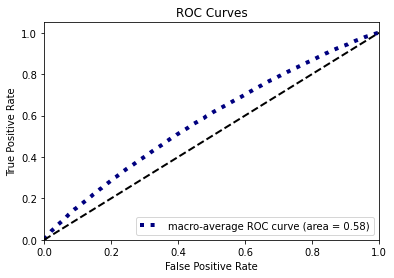

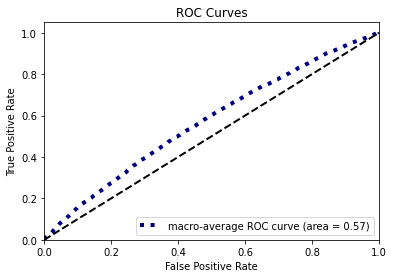

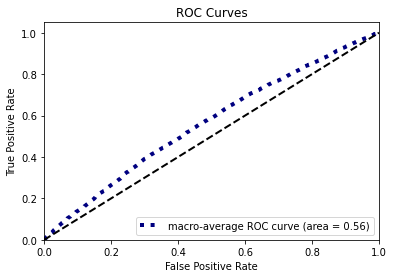

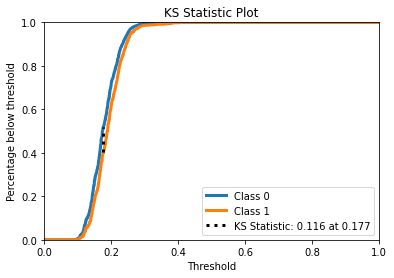

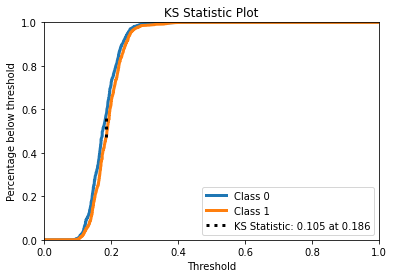

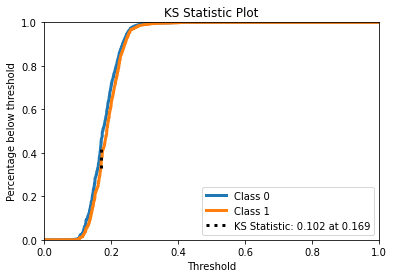

In [140]:
plot_roc_curve(y_probas=lr.predict_proba(train[varw]),y_true=train[vart[0]],curves='macro')
plot_roc_curve(y_probas=lr.predict_proba(val[varw]),y_true=val[vart[0]],curves='macro')
plot_roc_curve(y_probas=lr.predict_proba(test[varw]),y_true=test[vart[0]],curves='macro')

plot_ks_statistic(y_probas=lr.predict_proba(train[varw]),y_true=train[vart[0]])
plot_ks_statistic(y_probas=lr.predict_proba(val[varw]),y_true=val[vart[0]])
plot_ks_statistic(y_probas=lr.predict_proba(test[varw]),y_true=test[vart[0]])

In [ ]:
score_base = 400
pdo = 52

## Scoring

In [247]:
score_base = 80
momios_base = 1
pdo = 10
factor = pdo/np.log(2)
offset = score_base-factor*np.log(momios_base)
n = len(varw)
factor,offset,n

(14.426950408889635, 80.0, 3)

In [248]:
betas,alpha = list(lr.coef_[0]),lr.intercept_[0]
betas,alpha

([-0.9766004407214856, -0.8241747168583912, -1.0010713641361075],
 -1.5052258542541934)

In [249]:
for beta,v in zip(betas,varw):
    train[f'P_{v}'] = np.round((-train[v]*beta+alpha/n)*factor+offset/n,0)
    val[f'P_{v}'] = np.round((-val[v]*beta+alpha/n)*factor+offset/n,0)
    test[f'P_{v}'] = np.round((-test[v]*beta+alpha/n)*factor+offset/n,0)

In [250]:
train['score'] = train.filter(like='P_').sum(axis=1)
val['score'] = val.filter(like='P_').sum(axis=1)
test['score'] = test.filter(like='P_').sum(axis=1)

In [251]:
aux = test['score'].describe().to_frame().T
aux['max'],aux['min'],aux['max']-aux['min']

(score    71.0
 Name: max, dtype: float64,
 score    42.0
 Name: min, dtype: float64,
 score    29.0
 dtype: float64)

<AxesSubplot:xlabel='score', ylabel='Density'>

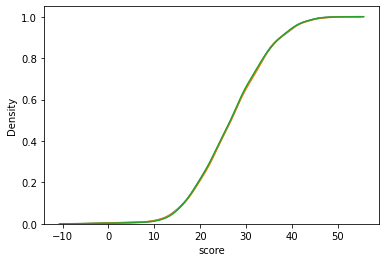

In [211]:
sns.kdeplot(data=train,x='score',cumulative=True)
sns.kdeplot(data=val,x='score',cumulative=True)
sns.kdeplot(data=test,x='score',cumulative=True)

In [282]:
len(range(10,460,50))

9

In [283]:
500/8

62.5

In [180]:
train['r_score'] = pd.cut(train['score'],bins=range(10,460,50),include_lowest=True).astype(str)
val['r_score'] = pd.cut(val['score'],bins=range(10,460,50),include_lowest=True).astype(str)
test['r_score'] = pd.cut(test['score'],bins=range(10,460,50),include_lowest=True).astype(str)

In [204]:
train[['d_q_5_c_tiempo_espera','P_w_d_q_5_c_tiempo_espera']].drop_duplicates()

,d_q_5_c_tiempo_espera,P_w_d_q_5_c_tiempo_espera
0,05. |553.0---13409.0|,7.0
2,01. |0.0---28.0|,44.0
3,03. |38.0---111.0|,37.0
6,02. |28.0---38.0|,34.0
7,04. |111.0---553.0|,25.0


### Scorecard

In [182]:
varp = [v for v in train.columns if v[:2]=='P_']
sc = []
for v in varp:
    nombre = "_".join(v.split('_')[2:])
    nombre = "_".join(nombre.split('_')[2:]) if nombre[:2]=='n_' else "_".join(nombre.split('_')[4:])
    aux = train[[v,v[4:]]].drop_duplicates().reset_index(drop=True).assign(caracteristica=nombre)
    aux.columns = ['puntos','atributo','caracteristica']
    sc.append(aux)
aux = pd.concat(sc,ignore_index=True)
sc = aux.groupby(['caracteristica','atributo']).min()
sc

puntos
caracteristica atributo                      
cac            BUENAVISTA                 9.0
               CUICUILCO                 17.0
               GALERIAS COAPA            13.0
               GALERIAS PACHUCA          11.0
               GALERIAS TOLUCA           31.0
...                                       ...
tiempo_tramite 05. |2596.0---43507.0|    75.0
tramites       1                         27.0
               2                         34.0
               3                         44.0
               4                         43.0

[93 rows x 1 columns]

In [189]:
sc.to_clipboard()

## Reportes

In [183]:
aux = pd.concat([train.merge(df[um],on=um,how='inner')[um+vart+['r_score']].assign(muestra='ent'),\
val.merge(df[um],on=um,how='inner')[um+vart+['r_score']].assign(muestra='val'),\
test.merge(df[um],on=um,how='inner')[um+vart+['r_score']].assign(muestra='test')],ignore_index=True)

In [184]:
aux

,linea,fecha,target,r_score,muestra
0,2282764411,2021-03-29,0,"(210.0, 260.0]",ent
1,8117844991,2021-02-20,0,"(210.0, 260.0]",ent
2,5578825209,2021-08-03,0,"(210.0, 260.0]",ent
3,4421492203,2021-10-25,0,"(210.0, 260.0]",ent
4,2213694945,2021-04-23,0,"(210.0, 260.0]",ent
...,...,...,...,...,...
367416,9999966195,2021-12-17,0,"(160.0, 210.0]",test
367417,9999974393,2021-12-11,1,"(160.0, 210.0]",test
367418,9999975058,2021-12-08,1,"(110.0, 160.0]",test
367419,9999981332,2021-12-20,1,"(110.0, 160.0]",test


In [185]:
aux['fecha'] = pd.to_datetime(aux['fecha']).map(lambda x:x.strftime('%Y%m'))

In [186]:
aux.groupby(['fecha','r_score','muestra','target']).count().to_clipboard()

In [187]:
df['target'].value_counts(1)

0    0.781033
1    0.218967
Name: target, dtype: float64

In [188]:
aux['r_score'].value_counts()

(160.0, 210.0]    102366
(110.0, 160.0]     80631
(210.0, 260.0]     79642
(60.0, 110.0]      48251
(260.0, 310.0]     41941
(310.0, 360.0]      9258
(9.999, 60.0]       4622
(360.0, 410.0]       677
Name: r_score, dtype: int64